# Heart Disease Severity Prediction System
This AI project predicts the **severity of heart disease** (from 0 to 4) using health-related input features. It uses a **Random Forest Classifier**, trained on the UCI Heart Disease dataset.

# Goals:
- Predict whether a patient has heart disease
- Classify the severity: *No Disease* → *Life-Threatening*
- Use user input to make live predictions


Dataset upload

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/AI lab/project/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print(df.head())


Mounted at /content/drive
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4         

 Data Overview

In [2]:


print("\n Dataset Info:\n")
print(df.info())

print("\n Missing Values:\n", df.isnull().sum())

#  Renaming 'num' to 'target' for consistency
df.rename(columns={'num': 'target'}, inplace=True)

# View of target column distribution
print("\n Target Column Value Counts:\n", df['target'].value_counts())


 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

 Missing Values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps

columns

In [3]:
print(df.columns)


Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal',
       'target'],
      dtype='object')


 Droping Unnecessary Columns

In [4]:


columns_to_drop = ['id', 'dataset']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])



Handling Missing Data

In [5]:

#  Filing numeric columns with mean
for col in ['trestbps', 'chol', 'thalch', 'oldpeak']:
    df[col] = df[col].fillna(df[col].mean())

# Filing categorical columns with mode
for col in ['fbs', 'restecg', 'exang', 'slope']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Dropping rows with too many missing values
df = df.dropna(subset=['ca', 'thal'])

/tmp/ipython-input-5-3722266248.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


visualize outliers before

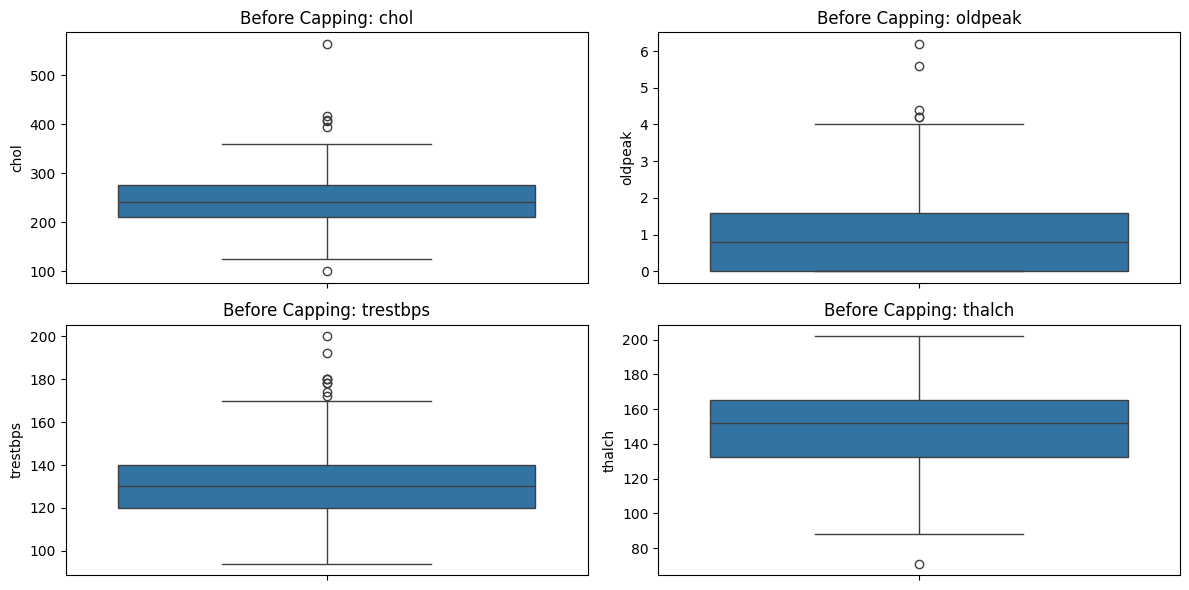

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_cap = ['chol', 'oldpeak', 'trestbps', 'thalch']

# Before capping
plt.figure(figsize=(12, 6))
for i, col in enumerate(features_to_cap):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"Before Capping: {col}")
plt.tight_layout()
plt.show()







Outlier count and apply capping in the same loop

In [7]:

# Cell 7: Outlier Capping using IQR and Counting Capped Values
features_to_cap = ['chol', 'oldpeak', 'trestbps', 'thalch']

print(" Outlier Capping Summary:")
for col in features_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count values that will be capped BEFORE applying clip
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f" {col}: {outliers} values capped")

    # Apply capping
    df[col] = df[col].clip(lower, upper)


 Outlier Capping Summary:
 chol: 6 values capped
 oldpeak: 5 values capped
 trestbps: 9 values capped
 thalch: 1 values capped


visualize after

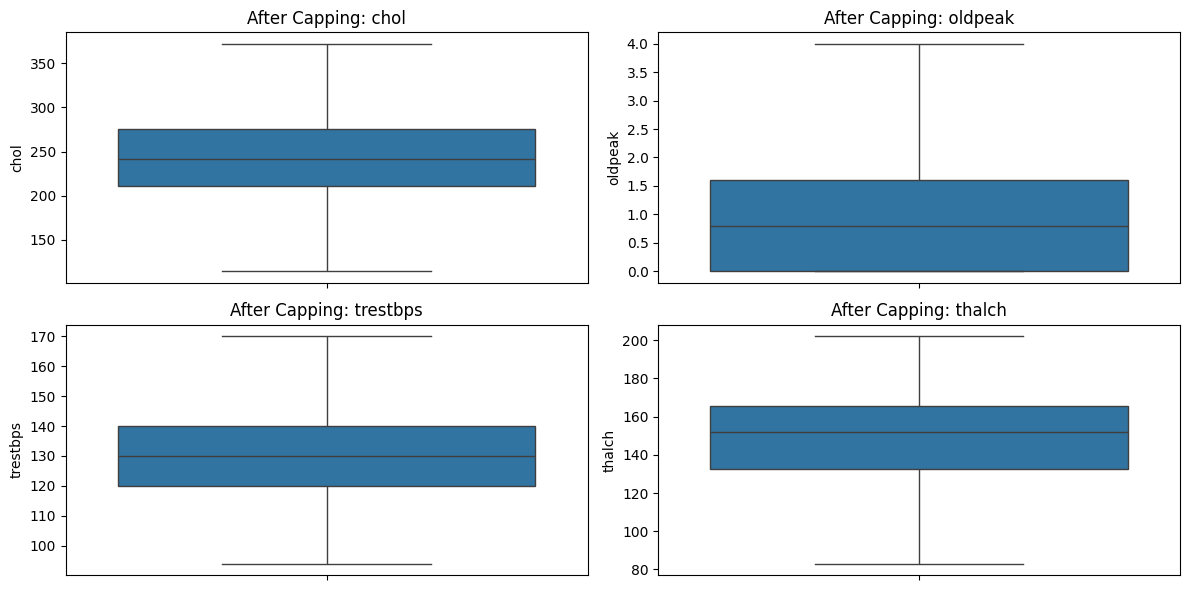

In [8]:
# After capping
plt.figure(figsize=(12, 6))
for i, col in enumerate(features_to_cap):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f"After Capping: {col}")
plt.tight_layout()
plt.show()


 Encoding Categorical Columns

In [9]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

 re-encode any remaining object-type columns

In [10]:
# Encode remaining object columns that are still text
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['severity']:  # skip severity which is for human-readable mapping
        df[col] = le.fit_transform(df[col])


Defining Features and Target

In [11]:

#SAFELY create severity AFTER X and y are finalized

# Remove target and weak features + make sure 'severity' is excluded
drop_cols = ['target', 'fbs', 'sex', 'restecg', 'exang', 'thal']
if 'severity' in df.columns:
    drop_cols.append('severity')

# Define input features and target
X = df.drop(columns=drop_cols)
y = df['target']

# Create severity column for later use in display
severity_map = {
    0: "No Disease",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Life-Threatening"
}
df['severity'] = df['target'].map(severity_map)





Stratified Train-Test Split ( Stratified sampling makes sure the proportions of classes (target labels) remain the same in both the training and testing sets.To check how well the model performs on new, unseen data using Train-Test Split)

In [12]:

from sklearn.model_selection import train_test_split

# Use stratified sampling to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 library designed to handle imbalanced datasets

In [13]:
!pip install imbalanced-learn


Before smot Resampling

/tmp/ipython-input-14-640096638.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


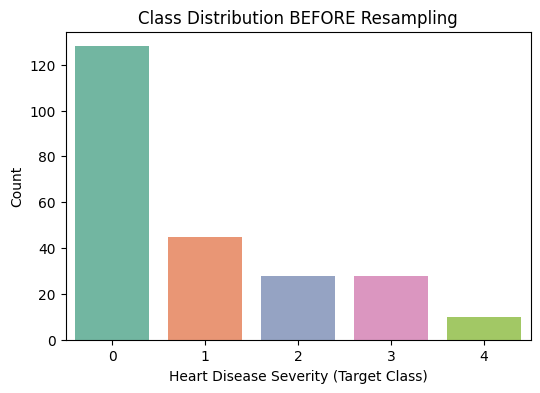

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize class distribution before resampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette='Set2')
plt.title("Class Distribution BEFORE Resampling")
plt.xlabel("Heart Disease Severity (Target Class)")
plt.ylabel("Count")
plt.show()


XGBoost(smote + tomek )
smote :Adds new synthetic examples for minority classes by interpolating between existing ones.
tomek: Identifies overlapping borderline points between classes and removes them to improve class separation.


/tmp/ipython-input-15-1458471642.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_sm, palette='Set1')


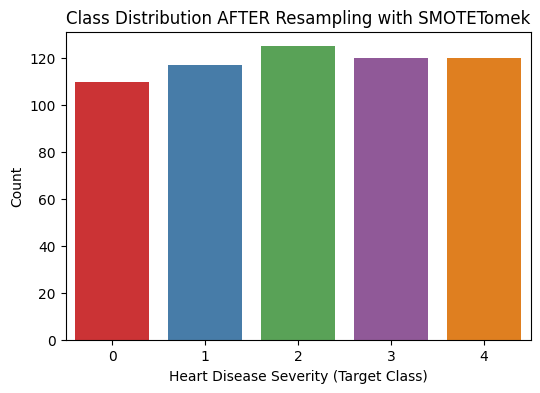

After SMOTETomek: Counter({2: 125, 4: 120, 3: 120, 1: 117, 0: 110})


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:


from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Apply SMOTETomek to training set
sm = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Visualize class distribution after resampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_sm, palette='Set1')
plt.title("Class Distribution AFTER Resampling with SMOTETomek")
plt.xlabel("Heart Disease Severity (Target Class)")
plt.ylabel("Count")
plt.show()

# Print counts
print("After SMOTETomek:", Counter(y_train_sm))

# Train XGBoost
model = XGBClassifier(eval_metric='mlogloss', random_state=42)
model.fit(X_train_sm, y_train_sm)




saving the model

In [22]:
import joblib
joblib.dump(model, 'heart_model.pkl')


['heart_model.pkl']

download saved model

In [23]:
from google.colab import files
files.download('heart_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stratified K-Fold Cross Validation

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Optional: Use cross-validation on original X, y
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')

print("\nCross-Validated F1 Macro Score (5-fold):", cv_scores.mean())


#Feature Importance
import numpy as np

# Show feature importances
importances = model.feature_importances_
feature_names = X.columns

print("\nFeature Importances:")
for name, importance in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {importance:.4f}")





Cross-Validated F1 Macro Score (5-fold): 0.2919719665925077

Feature Importances:
slope: 0.2775
ca: 0.1602
cp: 0.1202
thalch: 0.1008
oldpeak: 0.0934
chol: 0.0884
age: 0.0867
trestbps: 0.0729


Evaluating the Model

 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.27      0.36      0.31        11
           2       0.33      0.14      0.20         7
           3       0.12      0.14      0.13         7
           4       0.33      0.33      0.33         3

    accuracy                           0.55        60
   macro avg       0.38      0.36      0.36        60
weighted avg       0.57      0.55      0.55        60



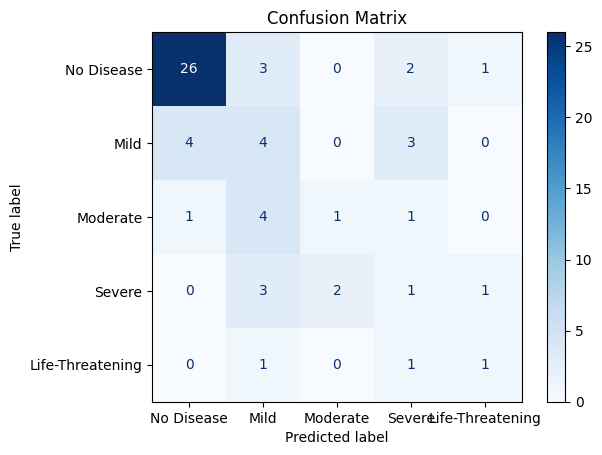

In [17]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
print(" Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=severity_map.values())
disp.plot(cmap='Blues')
import matplotlib.pyplot as plt
plt.title("Confusion Matrix")
plt.show()

Per-Class Precision/Recall/F1

In [18]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
print("\nDetailed Per-Class Metrics:")
for i, label in severity_map.items():
    print(f"{label}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}")



Detailed Per-Class Metrics:
No Disease: Precision=0.84, Recall=0.81, F1=0.83
Mild: Precision=0.27, Recall=0.36, F1=0.31
Moderate: Precision=0.33, Recall=0.14, F1=0.20
Severe: Precision=0.12, Recall=0.14, F1=0.13
Life-Threatening: Precision=0.33, Recall=0.33, F1=0.33


Predicting Sample Input

In [19]:

sample_input = pd.DataFrame([{
    'age': 63,
    'cp': 3,
    'trestbps': 145,
    'chol': 233,
    'thalch': 150,
    'oldpeak': 2.3,
    'slope': 0,
    'ca': 0.0
}])

predicted_class = model.predict(sample_input)[0]
print("\n Predicted class (0–4):", predicted_class)
print(" Predicted Disease Severity Level:", severity_map[predicted_class])



 Predicted class (0–4): 0
 Predicted Disease Severity Level: No Disease


Prediction Probabilities

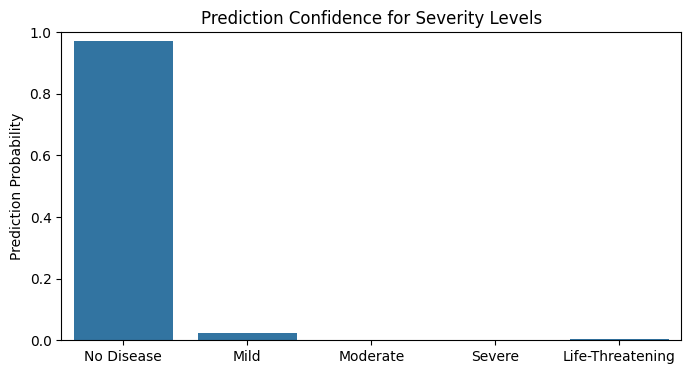

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

proba = model.predict_proba(sample_input)[0]

plt.figure(figsize=(8, 4))
sns.barplot(x=list(severity_map.values()), y=proba)
plt.ylabel("Prediction Probability")
plt.title("Prediction Confidence for Severity Levels")
plt.ylim(0, 1)
plt.show()


Predicting from User Input and bar chart of prediction probabilities

Age (e.g., 45): 23
Chest Pain Type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic): 2
Resting Blood Pressure (e.g., 120): 130
Cholesterol (e.g., 230): 200
Max Heart Rate Achieved (e.g., 150): 179
ST Depression (e.g., 1.4): 1.7
Slope of ST (0 = upsloping, 1 = flat, 2 = downsloping): 0
Number of major vessels (0–3): 2

 Predicted Heart Disease Severity: Severe


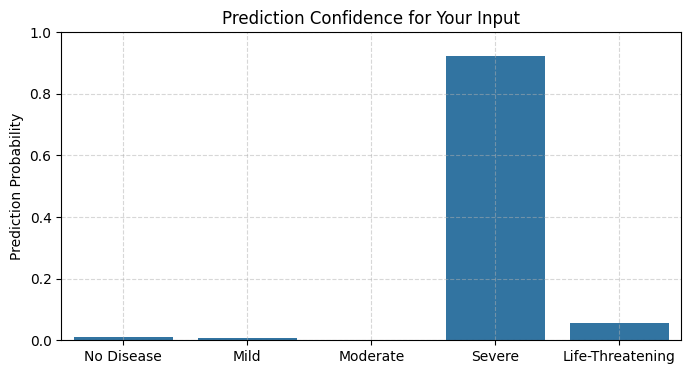

In [ ]:
def get_user_input():
    return pd.DataFrame([{
        'age': int(input("Age (e.g., 45): ")),
        'cp': int(input("Chest Pain Type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic): ")),
        'trestbps': int(input("Resting Blood Pressure (e.g., 120): ")),
        'chol': int(input("Cholesterol (e.g., 230): ")),
        'thalch': int(input("Max Heart Rate Achieved (e.g., 150): ")),
        'oldpeak': float(input("ST Depression (e.g., 1.4): ")),
        'slope': int(input("Slope of ST (0 = upsloping, 1 = flat, 2 = downsloping): ")),
        'ca': float(input("Number of major vessels (0–3): "))
    }])

# Predict
user_input = get_user_input()
user_pred = model.predict(user_input)[0]
print("\n Predicted Heart Disease Severity:", severity_map[user_pred])

# Show prediction probabilities
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

user_proba = model.predict_proba(user_input)[0]

plt.figure(figsize=(8, 4))
sns.barplot(x=list(severity_map.values()), y=user_proba)
plt.ylabel("Prediction Probability")
plt.title("Prediction Confidence for Your Input")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()




Feature Correlation Heatmap

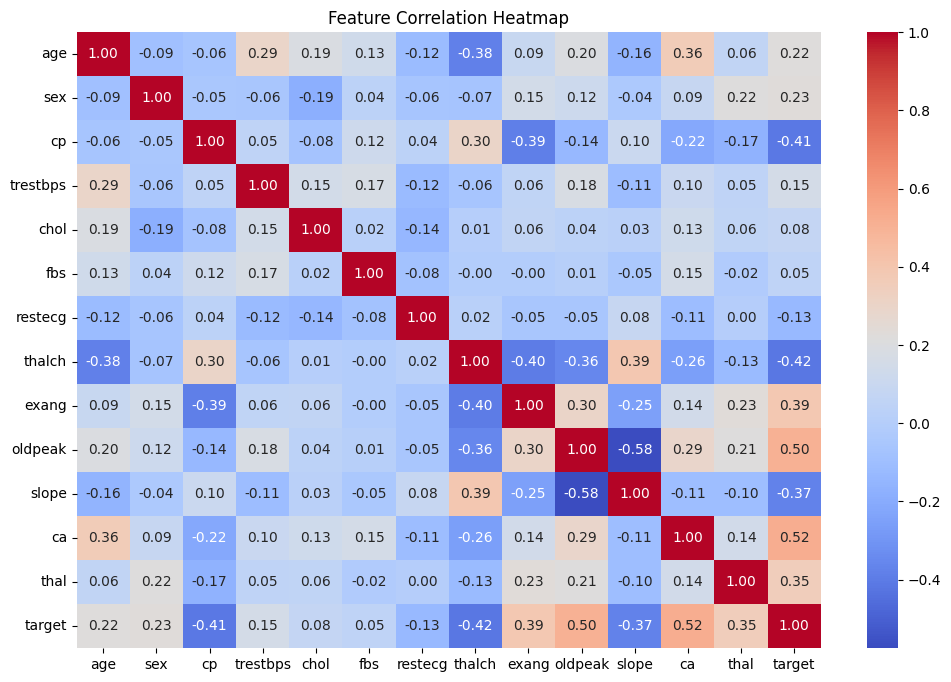

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
